# Traveling Salesman Problem (TSP)

The problem is the following : 

- A salesman wants to visit a number of cities $C=\{c_1, ..., c_n\}$ one after an other. 
- Each city is a fixed known distanced $d(c_i,c_j)=d_{i,j}$ from the other ones.

The goal is to find a good path to visit all the cities. Optionally, find the best path.

We will an evolutionary algorithm to find possible solutions.

**Individual** : 
- List of cities represented by integers.

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import scalene
import timeit
import random
import matplotlib.pyplot as plt

# Code

In [3]:
class individual:

    def __init__(
        self,
        n_cities = None,
        randomize = True,
        fixed = None
     ):
        self.n = n_cities
        if fixed:
            self.path = fixed
        else:
            self.path = [i for i in range(self.n)] # [1,..., n]
            if randomize:
                np.random.shuffle(self.path) # random permutation of 
        
    def evaluate(self, D):
        # Create an array of city indices from the path
        city_indices = np.array(self.path)
        
        # Create an array of next city indices by shifting the city_indices array by one position
        next_city_indices = np.roll(city_indices, shift=-1)
        
        # Use advanced indexing to get the distances from D
        distances = D[city_indices, next_city_indices]
        
        # Sum the distances to get the total distance
        total_distance = np.sum(distances)
        
        self.total_distance = total_distance
        return total_distance

    
    def mutate(self):
        # Swap c_i and c_j
        i, j = random.choices(range(self.n), k=2)
        self.path[i], self.path[j] = self.path[j], self.path[i]
        return self

    def crossover(self, other):
        # ordered crossover
        start, end = sorted(random.choices(range(self.n), k=2))
        segment = self.path[start:end+1]
        
        newborn_path = [-1] * self.n
        newborn_path[start:end+1] = segment
        
        pointer = (end + 1) % self.n
        for city in other.path:
            if city not in segment:
                newborn_path[pointer] = city
                pointer = (pointer + 1) % self.n
        
        return individual(n_cities=self.n, fixed=newborn_path)
    
    def __str__(self) -> str:
        res = str(self.path)
        return res

In [4]:
def compute_D(C):
    n = len(C)
    D = np.zeros((n,n))
    for i in range(n):
        for j in range(i):
            d = np.sqrt(np.sum((C[i]-C[j])**2))
            D[i][j] = d
    return D + D.T

In [5]:
n_cities = 7
C = np.random.random((n_cities,2))
D = compute_D(C)

In [6]:
individuals = [individual(n_cities=n_cities) for i in range(9)]
print(individuals[0])
print(individuals[1])
print(individuals[2])

[5, 0, 1, 3, 4, 6, 2]
[3, 4, 2, 5, 6, 0, 1]
[4, 3, 2, 0, 6, 1, 5]


In [7]:
total_distances = [ind.evaluate(D) for ind in individuals]
total_distances[:3]

[3.251724786755814, 3.1514709350732084, 3.5148973365568663]

## Visualization
The problem being visual, let's visualize it.

In [8]:
def visualize_path(individual, cities_coordinates, distance_matrix):
    """
    Visualize the path taken by an individual.
    
    Parameters:
    - individual: An instance of the 'individual' class.
    - cities_coordinates: A list of (x, y) coordinates for each city.
    """
    # Extract the x and y coordinates for the cities in the path
    x_coords = [cities_coordinates[city][0] for city in individual.path]
    y_coords = [cities_coordinates[city][1] for city in individual.path]
    
    # Add the starting city to the end to close the loop
    x_coords.append(x_coords[0])
    y_coords.append(y_coords[0])
    
    # Plot the cities as points
    plt.scatter(x_coords, y_coords, color='blue', marker='o')
    
    # Label the cities with their indices
    for i, city in enumerate(individual.path):
        plt.text(cities_coordinates[city][0], cities_coordinates[city][1], str(city), fontsize=12, ha='right')
    
    # Plot the path
    plt.plot(x_coords, y_coords, color='red', linestyle='-', linewidth=1)
    
    plt.title(f'Path taken by the salesman Distance: {individual.evaluate(distance_matrix):.2f}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

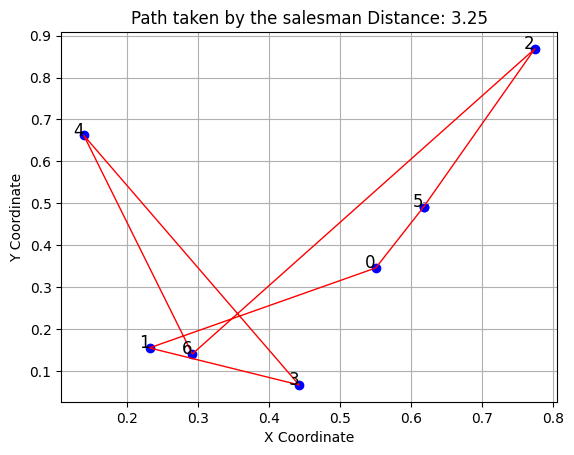

In [9]:
visualize_path(individuals[0], C, D)

In [10]:
def visualize_paths_grid(individuals, cities_coordinates, distance_matrix, grid_shape=None):
    """
    Visualize multiple paths in a grid of plots.
    
    Parameters:
    - individuals: A list of instances of the 'individual' class.
    - cities_coordinates: A list of (x, y) coordinates for each city.
    - distance_matrix: A matrix of distances between cities.
    - grid_shape: Tuple specifying the shape of the grid (rows, columns). If None, a square grid is used.
    """
    n_individuals = len(individuals)
    
    # Determine grid shape if not provided
    if not grid_shape:
        grid_size = int(np.ceil(np.sqrt(n_individuals)))
        grid_shape = (grid_size, grid_size)
    
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(15, 15))
    
    # Flatten axes for easy iteration
    axes = axes.ravel()
    
    for i, ind in enumerate(individuals):
        ax = axes[i]
        
        # Plot cities
        for city_coord in cities_coordinates:
            ax.scatter(city_coord[0], city_coord[1], color='blue', marker='o')
        
        # Plot individual's path
        x_coords = [cities_coordinates[city][0] for city in ind.path]
        y_coords = [cities_coordinates[city][1] for city in ind.path]
        
        # Add the starting city to the end to close the loop
        x_coords.append(x_coords[0])
        y_coords.append(y_coords[0])
        
        ax.plot(x_coords, y_coords, color='red', linestyle='-', linewidth=1)
        ax.set_title(f'Path {i+1} - Distance: {ind.evaluate(distance_matrix):.2f}')
        ax.grid(True)
    
    # Remove any unused subplots
    for i in range(n_individuals, grid_shape[0] * grid_shape[1]):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

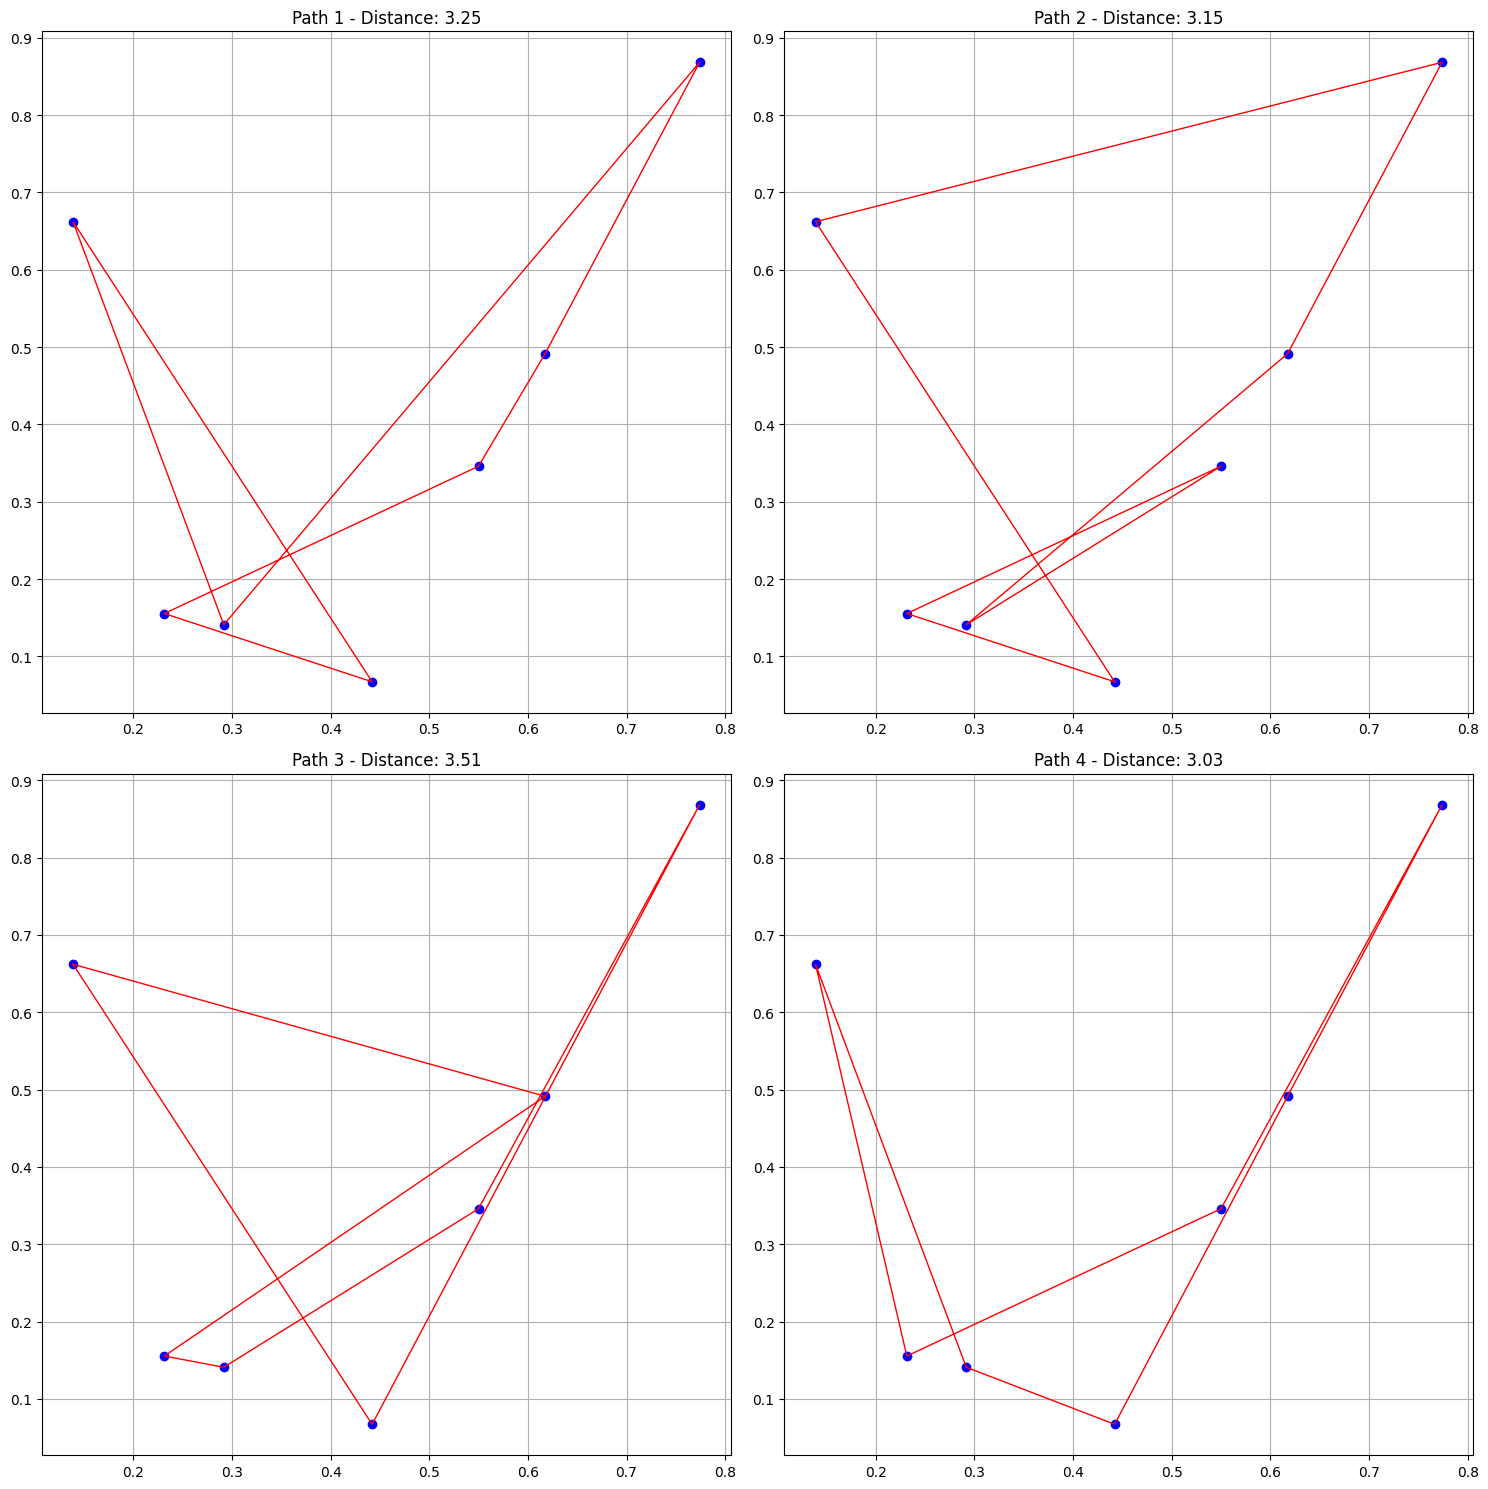

In [11]:
visualize_paths_grid(individuals[:4], C, D)

# Creating the algorithm

In [12]:
def compute_fitness(individual):
    global global_distance_matrix
    return 1 / individual.evaluate(global_distance_matrix)

def epoch(individuals, alpha=0.5, beta=1, gamma=0.5):
    
    n_individuals = len(individuals)
    
    # 1. Selection
    # Parallelizing the fitness computation using multiprocessing
    fitnesses = [compute_fitness(ind) for ind in individuals]
    
    total_fitness = sum(fitnesses)
    probabilities = [f / total_fitness for f in fitnesses]
    selected_parents = np.random.choice(individuals, size=n_individuals, p=probabilities)

    # 2. Crossover
    n_crossover = int(n_individuals * gamma)
    offspring = []
    for _ in range(n_crossover // 2):  # //2 because each iteration produces 2 offspring
        parent1, parent2 = random.choices(selected_parents, k=2)
        child1 = parent1.crossover(parent2)
        child2 = parent2.crossover(parent1)
        offspring.extend([child1, child2])
    
    # 3. Mutation
    n_mutation = int(n_individuals * alpha)
    for _ in range(n_mutation):
        individual_to_mutate = random.choice(offspring)
        n_genes_to_mutate = 1#int(beta * individual_to_mutate.n)
        for _ in range(n_genes_to_mutate):
            individual_to_mutate.mutate()
    
    # 4. Replacement
    individuals = np.concatenate([offspring[:n_individuals], selected_parents[:n_individuals - len(offspring)]])
    
    return individuals

In [13]:
global_distance_matrix = D
individuals = epoch(individuals, 0.5, 0.5, 0.5)

In [14]:
print(individuals[0]), len(individuals)

[3, 4, 5, 0, 2, 6, 1]


(None, 9)

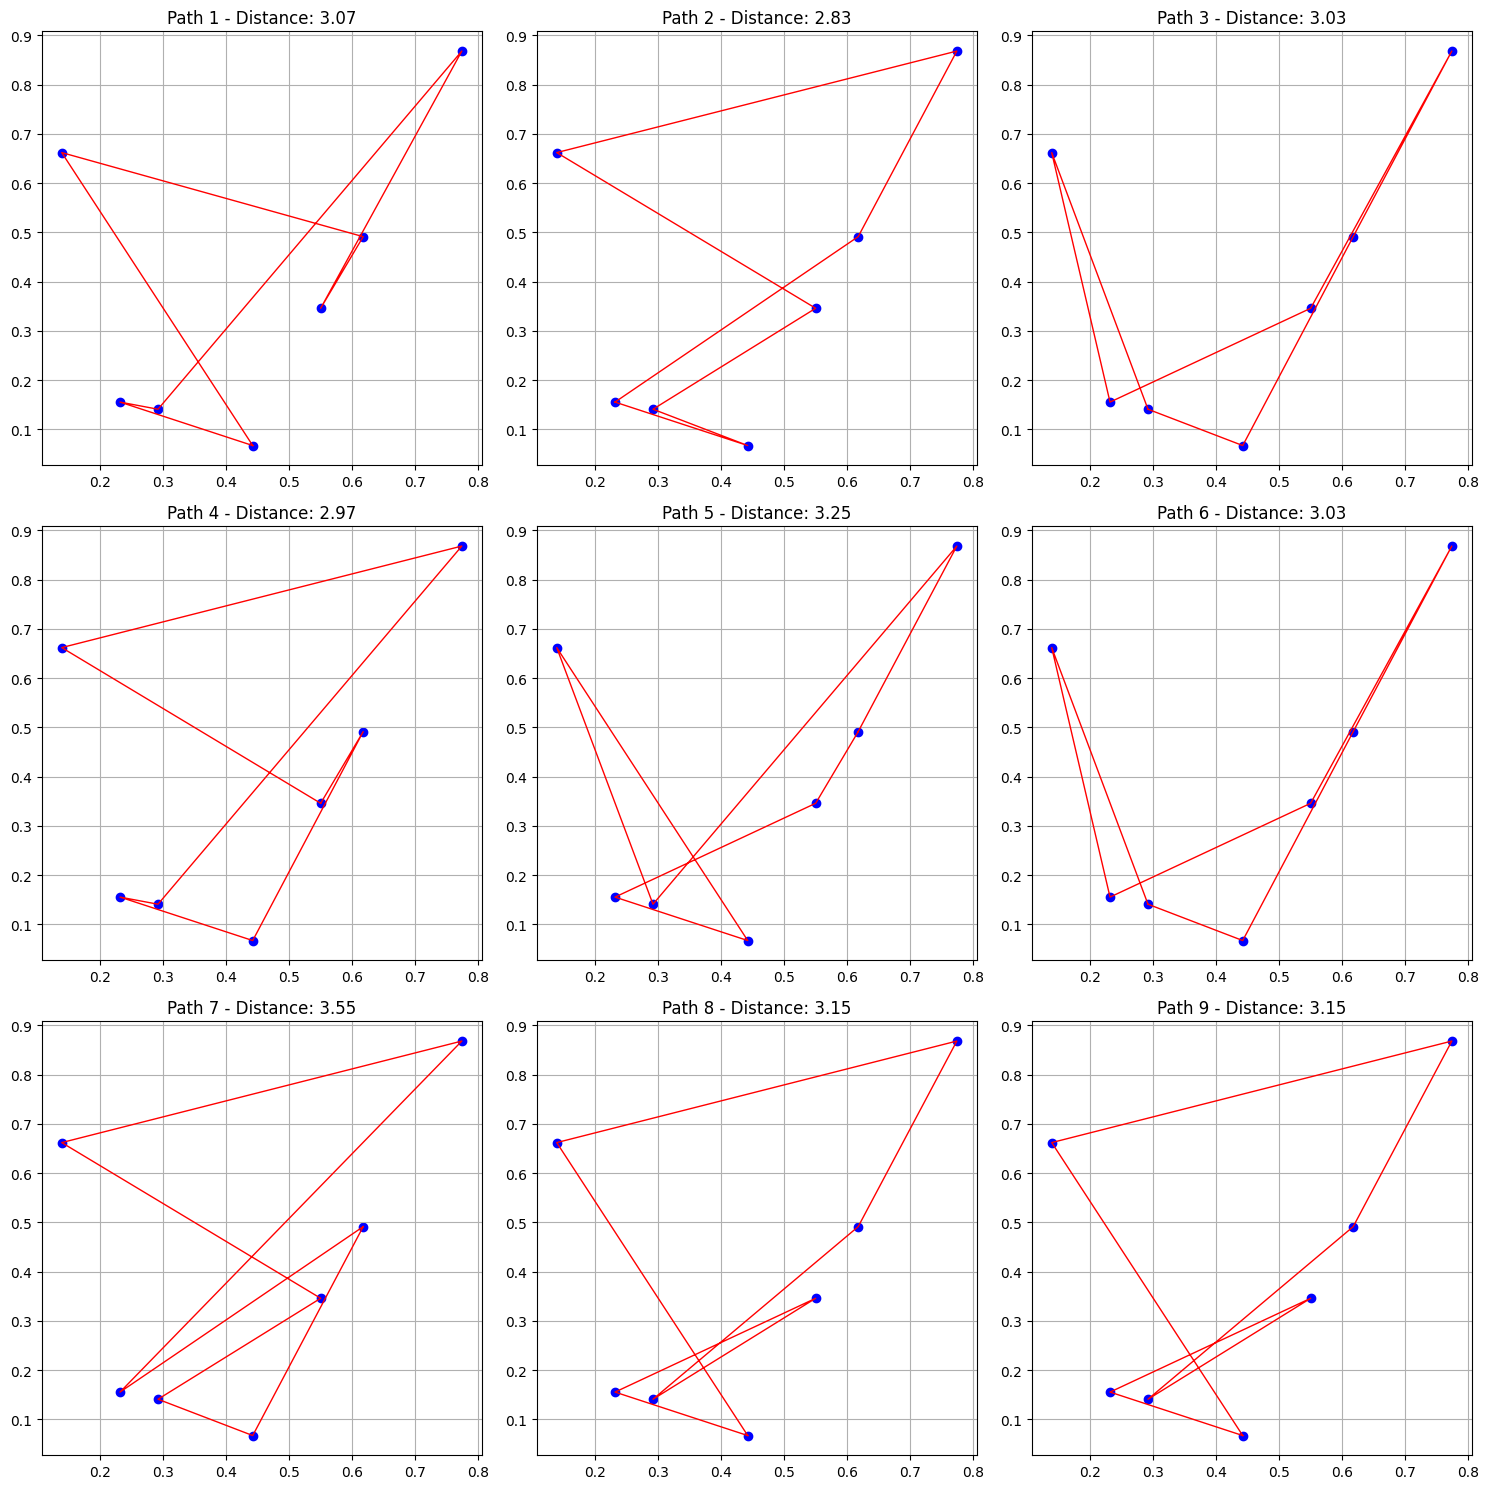

In [15]:
visualize_paths_grid(individuals, C, D)

In [16]:
import pandas as pd

def update_statistics(df, iteration, individuals):
    # Iteration step
    step = iteration
    
    global global_distance_matrix
    distance_matrix = global_distance_matrix

    # Best individual
    scores = [ind.evaluate(distance_matrix) for ind in individuals]
    best_individual = min(individuals, key=lambda x: x.evaluate(distance_matrix))
    
    # Number of same individuals
    unique_individuals = set(tuple(ind.path) for ind in individuals)
    num_same_individuals = len(individuals) - len(unique_individuals)
    
    # Number of shared patterns between individuals
    # Here, we'll count shared subpaths of length 3 as an example
    patterns = []
    for ind in individuals:
        for i in range(len(ind.path) - 2):
            patterns.append(tuple(ind.path[i:i+3]))
    num_shared_patterns = len(patterns) - len(set(patterns))
    
    # Score
    best_score = best_individual.total_distance
    
    # Append to DataFrame
    new_row = {
        'Iteration': step,
        'Best Individual': str(best_individual.path),
        'Number of Same Individuals': num_same_individuals,
        'Number of Shared Patterns': num_shared_patterns,
        'Score': best_score,
        'All Scores': scores
    }
    df = df.append(new_row, ignore_index=True)
    
    return df

In [17]:
# Intialize a new problem
n_cities = 10
C = np.random.randint(0, 1000, (n_cities, n_cities))
D = compute_D(C)
D = (D-np.min(D))/(np.max(D)-np.min(D))
global_distance_matrix = D

# Initialize DataFrame
columns = ['Iteration', 'Best Individual', 'Number of Same Individuals', 'Number of Shared Patterns', 'Score']
statistics_df = pd.DataFrame(columns=columns)

individuals = [individual(n_cities=n_cities) for _ in range(100)]

for i in tqdm(range(100)):
    individuals = epoch(individuals, 0.5, 0.75, 0.1)
    statistics_df = update_statistics(statistics_df, i, individuals)

100%|██████████| 100/100 [00:01<00:00, 54.08it/s]


In [18]:
statistics_df

,Iteration,Best Individual,Number of Same Individuals,Number of Shared Patterns,Score,All Scores
0,0,"[2, 9, 4, 8, 6, 7, 5, 3, 1, 0]",35,421,6.478550,"[6.8988281504352384, 7.39215078865616, 6.95840..."
1,1,"[0, 7, 2, 9, 8, 6, 5, 4, 3, 1]",41,457,6.495320,"[6.747141678074988, 6.495320236497445, 6.92760..."
2,2,"[0, 7, 2, 9, 8, 6, 5, 4, 3, 1]",47,479,6.495320,"[7.248602193784377, 6.886216046721625, 7.13602..."
3,3,"[8, 2, 7, 0, 4, 3, 1, 5, 6, 9]",48,488,6.426666,"[7.151344849957351, 6.549786877294922, 7.12305..."
4,4,"[9, 8, 4, 7, 6, 2, 1, 3, 5, 0]",52,509,6.500798,"[6.612310038129948, 6.779675781754862, 7.01856..."
...,...,...,...,...,...,...
95,95,"[9, 2, 7, 5, 3, 6, 1, 0, 4, 8]",63,559,6.345273,"[6.656455682473256, 6.763438173380831, 6.79794..."
96,96,"[2, 8, 9, 5, 1, 3, 4, 6, 7, 0]",59,542,6.555083,"[7.0136908903664, 7.349808063734792, 7.1309247..."
97,97,"[2, 8, 1, 6, 7, 0, 4, 9, 5, 3]",58,530,6.576200,"[7.366143106221893, 7.079453181662397, 6.57619..."
98,98,"[7, 2, 4, 8, 5, 0, 1, 3, 6, 9]",59,548,6.537240,"[7.4346643855279755, 6.537239868231477, 6.6129..."


<AxesSubplot: >

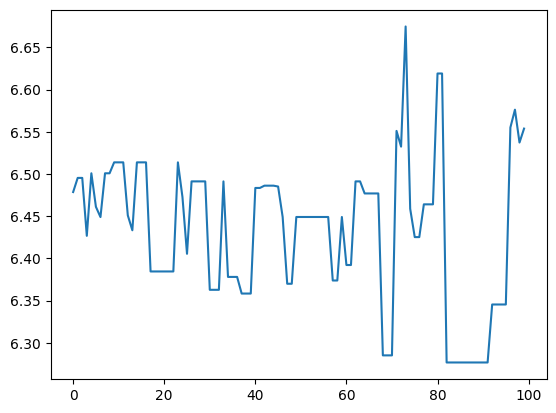

In [19]:
statistics_df['Score'].plot()

<AxesSubplot: >

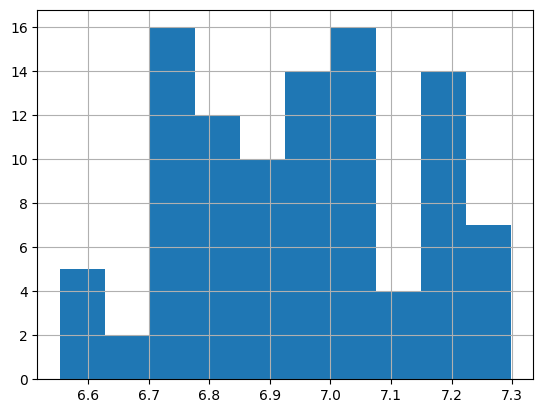

In [20]:
statistics_df['All Scores'][-1:].hist()

<AxesSubplot: >

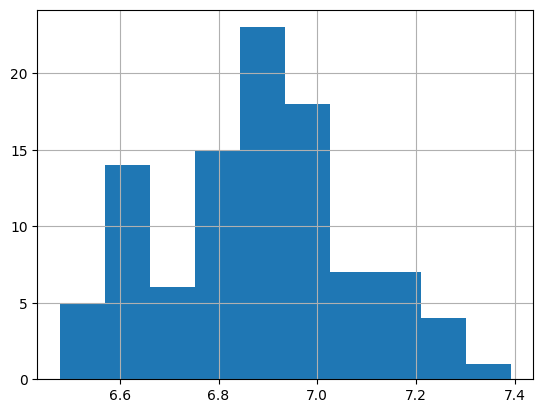

In [21]:
statistics_df['All Scores'][:1].hist()

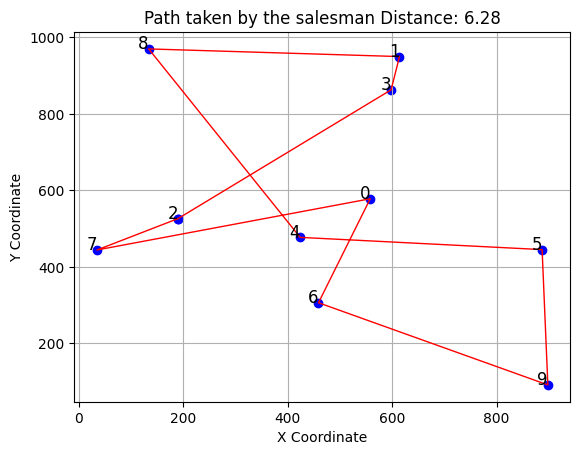

In [23]:
best_iteration = np.argmin(statistics_df['Score'])
best_individual_path = statistics_df['Best Individual'].iloc[best_iteration]
best_individual_path = [int(x) for x in best_individual_path[1:-1].split(', ')]
best_individual = individual(n_cities=n_cities, fixed=best_individual_path)
visualize_path(best_individual,C,D)

## Now, we stress test

### French cities

#### Import and transform data

In [3]:
french_cities = pd.read_json('./fr.json')
french_cities

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Paris,48.8567,2.3522,France,FR,Île-de-France,primary,11060000,2148271
1,Marseille,43.2964,5.3700,France,FR,Provence-Alpes-Côte d’Azur,admin,870731,870731
2,Lyon,45.7600,4.8400,France,FR,Auvergne-Rhône-Alpes,admin,522969,522969
3,Toulouse,43.6045,1.4440,France,FR,Occitanie,admin,493465,493465
4,Nice,43.7034,7.2663,France,FR,Provence-Alpes-Côte d’Azur,minor,342669,342669
...,...,...,...,...,...,...,...,...,...
629,Saint-Laurent-sur-Saône,46.3053,4.8394,France,FR,Auvergne-Rhône-Alpes,,1689,1688
630,La Neuvillette-lès-Reims,49.2890,4.0058,France,FR,Grand Est,,1567,1567
631,Laleu,46.1689,-1.1994,France,FR,Nouvelle-Aquitaine,,1149,1149
632,La Walck,48.8497,7.6108,France,FR,Grand Est,,1042,1042


In [10]:
C.to_json('./city_lat_lng.json', lines=True, orient='records')

In [4]:
C = french_cities[['city','lat','lng']]
C

,city,lat,lng
0,Paris,48.8567,2.3522
1,Marseille,43.2964,5.3700
2,Lyon,45.7600,4.8400
3,Toulouse,43.6045,1.4440
4,Nice,43.7034,7.2663
...,...,...,...
629,Saint-Laurent-sur-Saône,46.3053,4.8394
630,La Neuvillette-lès-Reims,49.2890,4.0058
631,Laleu,46.1689,-1.1994
632,La Walck,48.8497,7.6108


In [26]:
def compute_spherical_D(df):
    n = df.shape[0]
    r = 6371e3 # earth radius
    D = np.zeros((n,n))
    for i in tqdm(range(n)):
        lat1 = df["lat"].iloc[i]
        phi1 = lat1 * np.pi / 180

        lng1 = df["lng"].iloc[i]
        tht1 = lng1 * np.pi / 180

        for j in range(i):
            lat2 = df["lat"].iloc[j]
            phi2 = lat2 * np.pi / 180
            dphi = phi2-phi1
            
            lng2 = df["lng"].iloc[j]
            tht2 = lng2 * np.pi / 180
            dtht = tht2-tht1

            a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dtht/2)**2
            c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
            d = r*c

            D[i][j] = d
    return D + D.T

In [27]:
D_spherical_france = compute_spherical_D(french_cities)
D_spherical_france

100%|██████████| 634/634 [00:20<00:00, 31.03it/s] 


array([[     0.        , 660504.60457205, 392057.41908074, ...,
        400500.54047519, 384670.76628605, 392155.72559252],
       [660504.60457205,      0.        , 277140.98157217, ...,
        609053.07497976, 641157.54133301, 868885.58369867],
       [392057.41908074, 277140.98157217,      0.        , ...,
        468891.66660773, 402030.25118124, 666338.62490531],
       ...,
       [400500.54047519, 609053.07497976, 468891.66660773, ...,
             0.        , 725191.54935143, 295705.64185533],
       [384670.76628605, 641157.54133301, 402030.25118124, ...,
        725191.54935143,      0.        , 776780.47731755],
       [392155.72559252, 868885.58369867, 666338.62490531, ...,
        295705.64185533, 776780.47731755,      0.        ]])

#### Visualize
Does it makes sense ?

In [28]:
distances_df = pd.DataFrame(D_spherical_france, columns=french_cities.city.to_list())
distances_df.index = distances_df.columns
distances_df

,Paris,Marseille,Lyon,Toulouse,Nice,Nantes,Montpellier,Strasbourg,Bordeaux,Lille,...,Hesdin,Les Roches-de-Condrieu,Neuf-Brisach,Cravanche,Lannoy,Saint-Laurent-sur-Saône,La Neuvillette-lès-Reims,Laleu,La Walck,Châtelaudren
Paris,0.000000,660504.604572,392057.419081,588168.854817,685941.788291,342707.692931,594838.827655,396754.777545,499113.729472,203365.713098,...,170261.907713,420178.916838,392980.024919,357577.289544,210427.853034,339500.806781,129688.100464,400500.540475,384670.766286,392155.725593
Marseille,660504.604572,0.000000,277140.981572,318738.625990,159502.510488,695079.110192,125498.568092,615829.237888,505263.654656,833763.734889,...,826628.378648,244541.607691,551112.796212,497743.736348,835586.872429,337181.018112,674507.977579,609053.074980,641157.541333,868885.583699
Lyon,392057.419081,277140.981572,0.000000,359849.114635,298349.843005,515389.039219,250686.859139,383084.411330,435992.483871,557107.857218,...,553644.419304,34584.808454,323654.226822,259654.691836,558694.975236,60634.611190,397367.504866,468891.666608,402030.251181,666338.624905
Toulouse,588168.854817,318738.625990,359849.114635,0.000000,468448.462688,464863.066184,195899.592131,736122.383326,211852.744967,790397.659292,...,754090.594620,334127.735675,680193.790686,614767.954557,796439.559513,401883.998727,661754.513444,353052.354342,751279.247892,645843.900999
Nice,685941.788291,159502.510488,298349.843005,468448.462688,0.000000,790410.398038,272813.796510,543872.940187,637104.306140,832742.017208,...,840480.824165,277485.145294,480200.683100,440564.368769,832353.034918,346530.801576,669194.582862,720092.398354,572852.878542,953726.982162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Saint-Laurent-sur-Saône,339500.806781,337181.018112,60634.611190,401883.998727,346530.801576,497221.853503,308906.645432,334513.197714,452083.944105,498215.866075,...,497518.705961,94922.262358,278538.316038,212941.205857,499503.003127,0.000000,337558.705418,464584.090140,351035.105640,637686.483546
La Neuvillette-lès-Reims,129688.100464,674507.977579,397367.504866,661754.513444,669194.582862,471416.301222,631341.323663,284196.171482,604215.266446,163568.644293,...,185751.227466,430368.837581,294783.489678,276519.870684,163341.098262,337558.705418,0.000000,521252.972903,267096.768328,516353.959469
Laleu,400500.540475,609053.074980,468891.666608,353052.354342,720092.398354,119738.394120,490528.778425,724544.336712,155449.954578,586827.515334,...,525252.473211,469173.849091,691510.879775,631726.596210,596403.629231,464584.090140,521252.972903,0.000000,725191.549351,295705.641855
La Walck,384670.766286,641157.541333,402030.251181,751279.247892,572852.878542,704607.081855,649172.742043,31234.204337,765378.293699,382156.462069,...,435782.942265,434510.174025,92669.780452,144914.718805,375007.664088,351035.105640,267096.768328,725191.549351,0.000000,776780.477318


<AxesSubplot: >

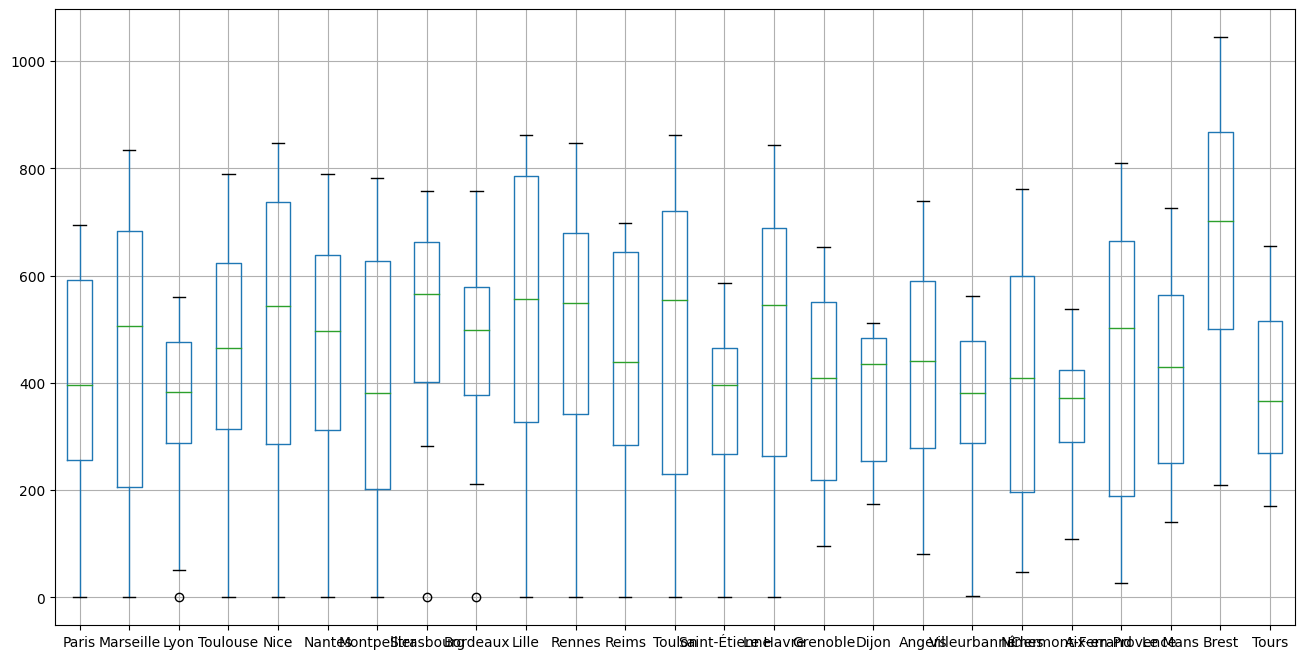

In [30]:
(distances_df.iloc[:25].T.iloc[:15]/1000).boxplot(figsize=(16,8))

### Train the EA

In [32]:
#%%prun
# Intialize a new problem
n_cities = 50#french_cities.shape[0]
global_distance_matrix = (D_spherical_france-np.min(D_spherical_france))/(np.max(D_spherical_france)-np.min(D_spherical_france))

# Initialize DataFrame
columns = ['Iteration', 'Best Individual', 'Number of Same Individuals', 'Number of Shared Patterns', 'Score']
statistics_df = pd.DataFrame(columns=columns)

individuals = [individual(n_cities=n_cities) for _ in range(1_000)]

for i in tqdm(range(1_000)):
    individuals = epoch(individuals, 0.5, 0.01, 0.1)
    statistics_df = update_statistics(statistics_df, i, individuals)

100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]


In [33]:
def train(max_cities, n_individuals, initial_alpha, initial_beta, initial_gamma, max_iterations=1_000, early_stopping_rounds=250):
    global global_distance_matrix
    n_cities = min(max_cities, global_distance_matrix.shape[0])
    
    # Initialize DataFrame
    columns = ['Iteration', 'Best Individual', 'Number of Same Individuals', 'Number of Shared Patterns', 'Score']
    statistics_df = pd.DataFrame(columns=columns)

    individuals = [individual(n_cities=n_cities) for _ in range(n_individuals)]
    
    best_score = float('inf')
    no_improvement_counter = 0
    
    alpha, beta, gamma = initial_alpha, initial_beta, initial_gamma
    
    for i in tqdm(range(max_iterations)):
        individuals = epoch(individuals, alpha, beta, gamma)
        statistics_df = update_statistics(statistics_df, i, individuals)
        
        current_score = statistics_df.iloc[-1]['Score']
        
        # Score tracking
        if current_score < best_score:
            best_score = current_score
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
        
        # Early stopping
        if no_improvement_counter >= early_stopping_rounds:
            print(f"Early stopping after {i} iterations.")
            break
        
        # Gradual change of hyperparameters (example: linear decay)
        decay_rate = 0.99  # Adjust as needed
        alpha *= decay_rate
        if alpha < 0.01 or no_improvement_counter > early_stopping_rounds //2:
            alpha = max(0.1,alpha)
        # beta *= decay_rate
        gamma *= decay_rate
        if gamma < 0.01:
            gamma = max(0.1, gamma)

    return statistics_df

In [34]:
results = train(
        max_cities=100,
        n_individuals=10_000,
        initial_alpha=0.01,
        initial_beta=0.01,
        initial_gamma=0.9,
        max_iterations=10_000,
        early_stopping_rounds=500,
        )

  1%|          | 117/10000 [05:48<8:11:00,  2.98s/it]


KeyboardInterrupt: 

In [ ]:
results.to_csv('./results.csv')

### Analyzing the results

In [36]:
results = pd.read_csv('./results/results_300_454990576400_1694501024815822400_52.13133339247041.csv')

<AxesSubplot: >

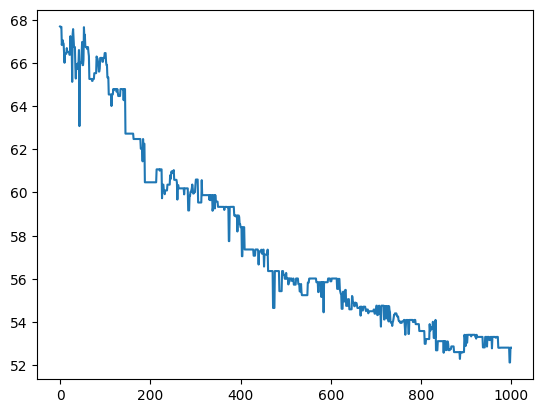

In [37]:
results.Score.plot()

In [38]:
import matplotlib.pyplot as plt

def visualize_path_cities(individual, cities_df, distance_matrix):
    """
    Visualize the path taken by an individual.
    
    Parameters:
    - individual: An instance of the 'individual' class.
    - cities_df: A DataFrame with columns 'city', 'lat', and 'lng'.
    """
    # Extract the lat and lng coordinates for the cities in the path
    lat_coords = [cities_df.loc[city, 'lat'] for city in individual.path]
    lng_coords = [cities_df.loc[city, 'lng'] for city in individual.path]
    
    # Add the starting city to the end to close the loop
    lat_coords.append(lat_coords[0])
    lng_coords.append(lng_coords[0])
    
    # Plot the cities as points
    plt.scatter(lng_coords, lat_coords, color='blue', marker='o')
    
    # Label the cities with their names
    for i, city in enumerate(individual.path):
        plt.text(cities_df.loc[city, 'lng'], cities_df.loc[city, 'lat'], city, fontsize=12, ha='right')
    
    # Plot the path
    plt.plot(lng_coords, lat_coords, color='red', linestyle='-', linewidth=1)
    
    plt.title(f'Path taken by the salesman Distance: {individual.evaluate(distance_matrix):.2f}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

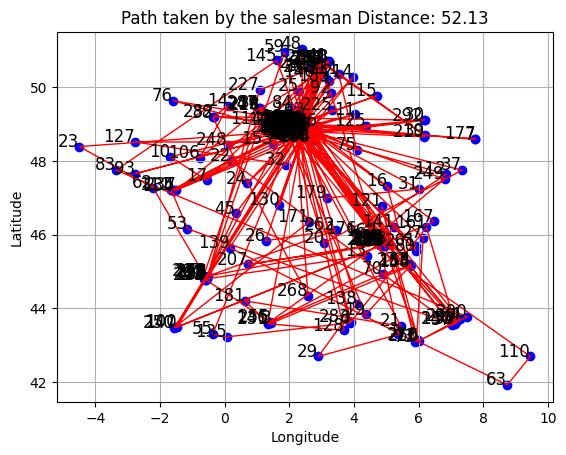

In [39]:
best_iteration = np.argmin(results['Score'])
best_individual_path = results['Best Individual'].iloc[best_iteration]
best_individual_path = [int(x) for x in best_individual_path[1:-1].split(', ')]
best_individual = individual(n_cities=n_cities, fixed=best_individual_path)
visualize_path_cities(best_individual,C,global_distance_matrix)

In [40]:
import folium

def visualize_path_on_map(individual, cities_df):
    """
    Visualize the path taken by an individual on an interactive map.
    
    Parameters:
    - individual: An instance of the 'individual' class.
    - cities_df: A DataFrame with columns 'city', 'lat', and 'lng'.
    """
    # Get the starting city's coordinates to center the map
    start_lat = cities_df.loc[individual.path[0], 'lat']
    start_lng = cities_df.loc[individual.path[0], 'lng']
    
    # Create a folium map centered on the starting city
    m = folium.Map(location=[start_lat, start_lng], zoom_start=5)
    
    # Add markers for each city in the path
    for city in individual.path:
        lat = cities_df.loc[city, 'lat']
        lng = cities_df.loc[city, 'lng']
        folium.Marker([lat, lng], tooltip=city).add_to(m)
    
    # Add lines connecting the cities in the order they are visited
    path_coords = [(cities_df.loc[city, 'lat'], cities_df.loc[city, 'lng']) for city in individual.path]
    path_coords.append(path_coords[0])  # Close the loop
    folium.PolyLine(path_coords, color="red", weight=2.5, opacity=0.5).add_to(m)
    
    return m

In [41]:
map_obj = visualize_path_on_map(best_individual, french_cities)
map_obj

In [ ]:
results

,Iteration,Best Individual,Number of Same Individuals,Number of Shared Patterns,Score,All Scores
0,0,"[75, 37, 97, 73, 55, 8, 57, 10, 89, 83, 78, 49...",45,521581,18.769678,"[24.748759822643642, 23.99473198999077, 25.219..."
1,1,"[99, 69, 48, 35, 25, 5, 46, 64, 31, 82, 17, 32...",65,565971,18.672066,"[30.294811010140887, 25.53141050967994, 24.926..."
2,2,"[47, 67, 22, 24, 38, 44, 11, 81, 23, 89, 86, 9...",79,584507,18.377716,"[25.355502875455443, 24.957921770051346, 24.40..."
3,3,"[98, 78, 32, 73, 21, 81, 17, 49, 46, 74, 38, 8...",71,595174,19.465890,"[25.887945037095548, 26.70229158435399, 26.514..."
4,4,"[70, 99, 23, 81, 82, 7, 89, 64, 32, 80, 41, 56...",109,603174,17.946617,"[26.158764651652817, 26.54763159049999, 26.948..."
...,...,...,...,...,...,...
8028,8028,"[23, 75, 10, 32, 62, 16, 31, 18, 70, 8, 99, 4,...",9805,973939,2.335133,"[5.648426182009741, 11.479827911673015, 12.878..."
8029,8029,"[23, 75, 10, 32, 62, 16, 31, 18, 70, 8, 99, 4,...",9807,973993,2.335133,"[11.652245489266427, 11.686004653408835, 11.79..."
8030,8030,"[23, 75, 10, 32, 62, 16, 31, 18, 70, 8, 99, 4,...",9806,973873,2.335133,"[14.047148689582498, 14.78636024408445, 4.9841..."
8031,8031,"[23, 75, 10, 32, 62, 16, 31, 18, 70, 8, 99, 4,...",9804,973734,2.335133,"[14.761073796040206, 8.211752052328897, 2.9815..."


In [ ]:
import plotly.express as px

In [ ]:
results['Iteration'] = results["Iteration"].astype(int)
results.dtypes

Iteration                       int32
Best Individual                object
Number of Same Individuals     object
Number of Shared Patterns      object
Score                         float64
All Scores                     object
dtype: object

In [ ]:
px.scatter_matrix(results[["Iteration",'Number of Same Individuals',"Number of Shared Patterns","Score"]].iloc[:1000], width=1200, height=1200,color="Iteration")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'dimensions': [{'axis': {'matches': True},
                              'label': 'Iteration',
                              'values': array([  0,   1,   2, ..., 997, 998, 999])},
                             {'axis': {'matches': True},
                              'label': 'Number of Same Individuals',
                              'values': array([45, 65, 79, ..., 8373, 8374, 8387], dtype=object)},
                             {'axis': {'matches': True},
                              'label': 'Number of Shared Patterns',
                              'values': array([521581, 565971, 584507, ..., 964939, 964695, 964924], dtype=object)},
                             {'axis': {'matches': True},
                              'label': 'Score',
                              'values': array([18.76967821, 18.67206638, 18.37771632, ...,  6.26873436,  6.26873436,
                                                6.26873436])}],
              'hovertemplate': ('%{xaxis.title.text}=%{x}<br>%{' ... '%{marker.color}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': array([  0,   1,   2, ..., 997, 998, 999]),
                         'coloraxis': 'coloraxis',
                         'symbol': 'circle'},
              'name': '',
              'showlegend': False,
              'type': 'splom'}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Iteration'}},
                             'colorscale': [[0.0, '#0d0887'], [0.1111111111111111,
                                            '#46039f'], [0.2222222222222222,
                                            '#7201a8'], [0.3333333333333333,
                                            '#9c179e'], [0.4444444444444444,
                                            '#bd3786'], [0.5555555555555556,
                                            '#d8576b'], [0.6666666666666666,
                                            '#ed7953'], [0.7777777777777778,
                                            '#fb9f3a'], [0.8888888888888888,
                                            '#fdca26'], [1.0, '#f0f921']]},
               'dragmode': 'select',
               'height': 1200,
               'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'width': 1200}
})

## Voronoi

In [ ]:
import numpy as np
import folium
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union
from shapely.geometry import MultiLineString
from shapely.geometry import Point

def voronoi_folium(vor, m, cities_df):
    # Create a bounding box around the cities
    min_x, min_y = cities_df[['lat', 'lng']].min() - 0.1  # -.1 for padding
    max_x, max_y = cities_df[['lat', 'lng']].max() + 0.1  # +.1 for padding
    bounding_box = Polygon([(min_x, min_y), (min_x, max_y), (max_x, max_y), (max_x, min_y)])
    
    # Convert Voronoi regions to Shapely polygons and clip to bounding box
    lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
    polygons = list(polygonize(MultiLineString(lines)))
    clipped_polygons = [polygon.intersection(bounding_box) for polygon in polygons]
    
    # Plot clipped Voronoi polygons on the folium map
    for polygon in clipped_polygons:
        if polygon.is_empty:
            continue
        coords = list(polygon.exterior.coords)
        folium.Polygon(coords, color="blue", fill=True, fill_opacity=0.4).add_to(m)

def create_voronoi_map(cities_df):
    # Extract coordinates from the DataFrame
    coords = cities_df[['lat', 'lng']].values
    
    # Compute Voronoi diagram
    vor = Voronoi(coords)
    
    # Create a folium map centered on the mean coordinates
    m = folium.Map(location=[coords[:,0].mean(), coords[:,1].mean()], zoom_start=5)
    
    # Add Voronoi polygons to the map
    voronoi_folium(vor, m, cities_df)
    
    # Add city markers to the map
    for index, row in cities_df.iterrows():
        folium.Marker([row['lat'], row['lng']], tooltip=row['city']).add_to(m)
    
    return m

# Example usage:
# cities_df should have columns 'city', 'lat', and 'lng'
# m = create_voronoi_map(cities_df)
# m

In [ ]:
m = create_voronoi_map(french_cities.iloc[:50])
m

In [42]:
def compute_voronoi_centroids(vor, cities_df):
    # Create a bounding box around the cities
    min_x, min_y = cities_df[['lat', 'lng']].min() - 1  # -1 for padding
    max_x, max_y = cities_df[['lat', 'lng']].max() + 1  # +1 for padding
    bounding_box = Polygon([(min_x, min_y), (min_x, max_y), (max_x, max_y), (max_x, min_y)])
    
    # Convert Voronoi regions to Shapely polygons and clip to bounding box
    lines = [LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
    polygons = list(polygonize(MultiLineString(lines)))
    clipped_polygons = [polygon.intersection(bounding_box) for polygon in polygons]
    
    # Compute centroids
    centroids = [polygon.centroid for polygon in clipped_polygons if not polygon.is_empty]
    
    return centroids

def greedy_path(centroids):
    remaining = centroids.copy()
    start = remaining.pop(0)
    path = [start]
    
    while remaining:
        next_point = min(remaining, key=lambda point: path[-1].distance(point))
        path.append(next_point)
        remaining.remove(next_point)
    
    return path + [path[0]]

def create_voronoi_path_map(cities_df):
    coords = cities_df[['lat', 'lng']].values
    vor = Voronoi(coords)
    centroids = compute_voronoi_centroids(vor, cities_df)
    path = greedy_path(centroids)
    
    m = folium.Map(location=[coords[:,0].mean(), coords[:,1].mean()], zoom_start=5)
    voronoi_folium(vor, m, cities_df)
    
    # Plot the path
    path_coords = [(point.x, point.y) for point in path]
    folium.PolyLine(path_coords, color="green", weight=2.5, opacity=0.01).add_to(m)
    
    return m

def create_voronoi_path_map_using_city_positions(cities_df):
    coords = cities_df[['lat', 'lng']].values
    vor = Voronoi(coords)
    
    m = folium.Map(location=[coords[:,0].mean(), coords[:,1].mean()], zoom_start=5)
    voronoi_folium(vor, m, cities_df)
    
    # Use city positions for the path
    path = greedy_path([Point(coord) for coord in coords])

    # Add city markers
    for index, row in cities_df.iterrows():
        folium.Marker([row['lat'], row['lng']], tooltip=row['city']).add_to(m)
    
    # Plot the path
    path_coords = [(point.x, point.y) for point in path]
    folium.PolyLine(path_coords, color="green", weight=5, opacity=0.8).add_to(m)
    
    return m, path

In [ ]:
m, path = create_voronoi_path_map_using_city_positions(french_cities.iloc[:50])
m

In [ ]:
def point_to_city_info(point, cities_df):
    """
    Translate a Point(x, y) into the corresponding city information (index, name, lat, lng).
    
    Parameters:
    - point: A shapely.geometry.Point object.
    - cities_df: A DataFrame with columns 'city', 'lat', and 'lng'.
    
    Returns:
    - A tuple (index, name, lat, lng) corresponding to the city.
    """
    # Compute the distance of the point to all cities
    distances = cities_df.apply(lambda row: point.distance(Point(row['lat'], row['lng'])), axis=1)
    
    # Find the index of the closest city
    closest_city_index = distances.idxmin()
    
    # Extract the city information
    row = cities_df.loc[closest_city_index]
    return (closest_city_index, row['city'], row['lat'], row['lng'])

path_info = pd.DataFrame(
    {point_to_city_info(point, french_cities) for point in path}
)

path_info.columns = ['Order','City','lat','lng']

In [ ]:
path_info

,Order,City,lat,lng
0,23,Brest,48.3900,-4.4900
1,36,Argenteuil,48.9500,2.2500
2,38,Caen,49.1800,-0.3700
3,1,Marseille,43.2964,5.3700
4,11,Reims,49.2628,4.0347
5,0,Paris,48.8567,2.3522
6,25,Amiens,49.8920,2.2990
7,34,Rouen,49.4428,1.0886
8,7,Strasbourg,48.5833,7.7458
9,4,Nice,43.7034,7.2663


In [ ]:
compute_score(path_info['Order'].to_list(), global_distance_matrix)

13.634498880547868

In [45]:
import threading

# A global variable
counter = 0

def increment_counter():
    global counter
    for _ in range(1000000):
        counter += 1

def decrement_counter():
    global counter
    for _ in range(1000000):
        counter -= 1

# Create two threads
t1 = threading.Thread(target=increment_counter)
t2 = threading.Thread(target=decrement_counter)

# Start the threads
t1.start()
t2.start()

# Wait for both threads to finish
t1.join()
t2.join()

print(counter)  # Output can be unpredictable


0


In [2]:
import pandas as pd
try:
    french_cities = pd.read_json('./fr.json')
except ValueError as e:
    print("Error reading JSON file:", e)

In [3]:
french_cities

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Paris,48.8567,2.3522,France,FR,Île-de-France,primary,11060000,2148271
1,Marseille,43.2964,5.3700,France,FR,Provence-Alpes-Côte d’Azur,admin,870731,870731
2,Lyon,45.7600,4.8400,France,FR,Auvergne-Rhône-Alpes,admin,522969,522969
3,Toulouse,43.6045,1.4440,France,FR,Occitanie,admin,493465,493465
4,Nice,43.7034,7.2663,France,FR,Provence-Alpes-Côte d’Azur,minor,342669,342669
...,...,...,...,...,...,...,...,...,...
629,Saint-Laurent-sur-Saône,46.3053,4.8394,France,FR,Auvergne-Rhône-Alpes,,1689,1688
630,La Neuvillette-lès-Reims,49.2890,4.0058,France,FR,Grand Est,,1567,1567
631,Laleu,46.1689,-1.1994,France,FR,Nouvelle-Aquitaine,,1149,1149
632,La Walck,48.8497,7.6108,France,FR,Grand Est,,1042,1042


In [5]:
french_cities.to_csv('fr.csv', index=False)

: 

In [4]:
with open('./fr.json', 'r') as json_file:
    json_content = json_file.read()
    print("JSON Content:")
    print(json_content)


JSON Content:
[
  {
    "city": "Paris", 
    "lat": "48.8567", 
    "lng": "2.3522", 
    "country": "France", 
    "iso2": "FR", 
    "admin_name": "Île-de-France", 
    "capital": "primary", 
    "population": "11060000", 
    "population_proper": "2148271"
  }, 
  {
    "city": "Marseille", 
    "lat": "43.2964", 
    "lng": "5.3700", 
    "country": "France", 
    "iso2": "FR", 
    "admin_name": "Provence-Alpes-Côte d’Azur", 
    "capital": "admin", 
    "population": "870731", 
    "population_proper": "870731"
  }, 
  {
    "city": "Lyon", 
    "lat": "45.7600", 
    "lng": "4.8400", 
    "country": "France", 
    "iso2": "FR", 
    "admin_name": "Auvergne-Rhône-Alpes", 
    "capital": "admin", 
    "population": "522969", 
    "population_proper": "522969"
  }, 
  {
    "city": "Toulouse", 
    "lat": "43.6045", 
    "lng": "1.4440", 
    "country": "France", 
    "iso2": "FR", 
    "admin_name": "Occitanie", 
    "capital": "admin", 
    "population": "493465", 
    "populati

In [11]:
import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv('./worldcities.csv')
df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629
...,...,...,...,...,...,...,...,...,...,...,...
44686,Numto,Numto,63.6667,71.3333,Russia,RU,RUS,Khanty-Mansiyskiy Avtonomnyy Okrug-Yugra,NaN,10.0,1643985006
44687,Nord,Nord,81.7166,-17.8000,Greenland,GL,GRL,NaN,NaN,10.0,1304217709
44688,Timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491
44689,San Rafael,San Rafael,-16.7795,-60.6799,Bolivia,BO,BOL,Santa Cruz,NaN,NaN,1068007388


In [28]:
df.iloc[:10_000][["city_ascii", "lat", "lng"]].to_json('./worldcities_10k.json',orient='records')